In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parimalmahata","key":"90b76789908258d827d399b003556427"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

 97% 321M/330M [00:01<00:00, 190MB/s]
100% 330M/330M [00:01<00:00, 189MB/s]


In [ ]:
!unzip face-mask-12k-images-dataset.zip

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from PIL import Image

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import cv2

In [6]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
trainset = torchvision.datasets.ImageFolder(root='/content/Face Mask Dataset/Train', transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/Face Mask Dataset/Test', transform=transform)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels.shape)

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([32])


In [11]:
classes = ['WithMask' , 'WithoutMask']

In [12]:
model = torchvision.models.resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [13]:
for p in model.parameters():
  p.requires_grad = False

In [14]:
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))

In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([1024, 2048])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([2, 512])
torch.Size([2])


In [17]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
loss_fn = nn.NLLLoss()
opt = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
def evaluation(dataloader):
    total, correct = 0, 0
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Epoch: 4/5, Test acc: 100.00, Train acc: 99.69


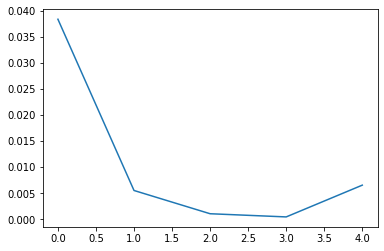

In [19]:
loss_epoch_arr = []
max_epochs = 5
min_loss = 1000
for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs,labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    model.train()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            del inputs, labels, outputs
            torch.cuda.empty_cache()
  loss_epoch_arr.append(loss.item())
  model.eval()
        
print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [20]:
model.load_state_dict(best_model)#print evaluation of just upto the checkpoint of model 
print(evaluation(trainloader), evaluation(testloader))

99.76 99.8991935483871


In [21]:
#SAVED THE BEST MODEL...
PATH = "/content/drive/MyDrive/mask_detection_model"
torch.save(model.state_dict(),PATH)

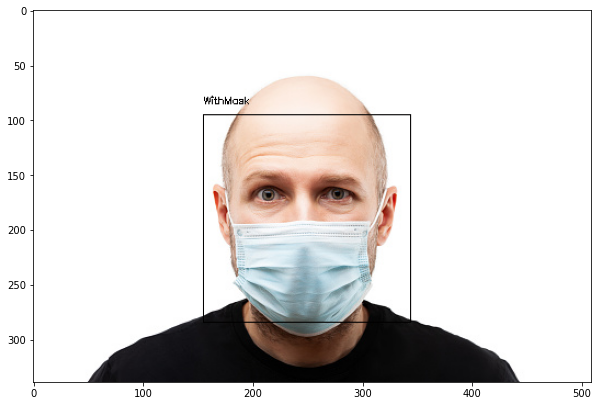

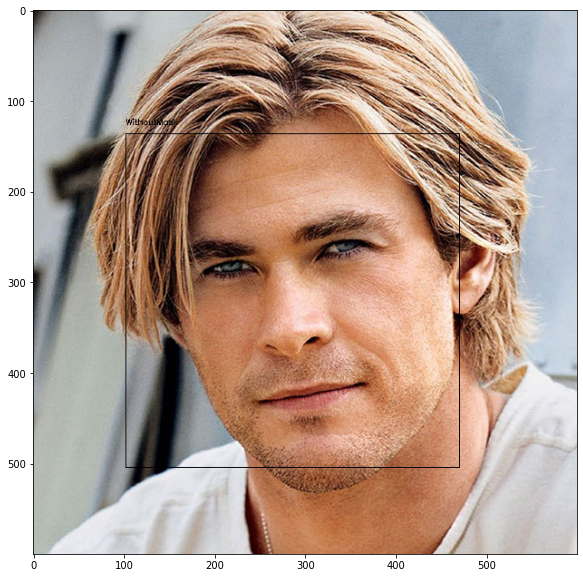

In [26]:
def mask_detector(img_path):
   face_model = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
   img = cv2.imread(img_path)
   img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
   faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples
   out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
   for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(224,224))
        crop = Image.fromarray(crop)
        mask_result = model(transform(crop).unsqueeze(0).to(device))
        cv2.putText(out_img,classes[mask_result.argmax()],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.3,2)
        cv2.rectangle(out_img,(x,y),(x+w,y+h),1)
   plt.figure(figsize=(10,10))
   plt.imshow(out_img)

mask_detector("/content/bm.jpg")
mask_detector("/content/bnm.jpg")
